In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.gridspec as mg
from PIL import Image
from scipy.stats import pearsonr, spearmanr
import pickle

plt.rcParams.update({
    "font.size": 9,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "figure.dpi": 150
})

In [15]:
# correlation tables (violins)
cross_seq_path  = "/project/deeprna_data/corgi-reproduction/processed_data/figure2/cross_region_tta/correlation_results.csv"
cross_cell_path = "/project/deeprna_data/corgi-reproduction/processed_data/figure2/cross_cell_tta/correlation_results.csv"
cross_both_path = "/project/deeprna_data/corgi-reproduction/processed_data/figure2/cross_both_tta/correlation_results.csv"

# gene-level true/predicted matrices for the cross_both scatter (panel d)
encode_matrix_path = "/project/deeprna_data/corgi-reproduction/processed_data/figure2/gene_level_cross_both/all_expressions_encode.csv"
grt_matrix_path    = "/project/deeprna_data/corgi-reproduction/processed_data/figure2/gene_level_cross_both/all_expressions_grt.csv"

# gene metadata and cell metadata
genes_info_path = "/project/deeprna_data/corgi-reproduction/data/Homo_sapiens.gene_info.tsv"
cells_path      = "/project/deeprna_data/corgi-reproduction/data/all_cell_types.csv"

# gene-level correlations
gene_cross_seq_path    = "/project/deeprna_data/corgi-reproduction/processed_data/figure2/gene_level_cross_region/correlations_fixed.pk"
gene_cross_cell_path = "/project/deeprna_data/corgi-reproduction/processed_data/figure2/gene_level_cross_celltype/correlations_fixed.pk"
gene_cross_both_path   = "/project/deeprna_data/corgi-reproduction/processed_data/figure2/gene_level_cross_both/correlations_fixed.pk"

# Six CTCF experiments are excluded due to extremely low data quality per FRiP scores.
exclude = [(212, 'ctcf'), (213, 'ctcf'), (214, 'ctcf'), (318, 'ctcf'), (319, 'ctcf'), (321, 'ctcf')]

# -------------------
# Load data into DataFrames (edit paths above as needed)
# -------------------
res_cross_seq  = pd.read_csv(cross_seq_path)
res_cross_cell = pd.read_csv(cross_cell_path)
res_cross_both = pd.read_csv(cross_both_path)

# matrices for panel (d)
encode_mat = pd.read_csv(encode_matrix_path, index_col=0, header='infer')
grt_mat    = pd.read_csv(grt_matrix_path, index_col=0, header='infer')

# gene & cell metadata
genes_df = pd.read_csv(genes_info_path, sep='\t')
cells = pd.read_csv(cells_path, index_col=0)

with open(gene_cross_seq_path, 'rb') as f:
    gene_cross_seq = pickle.load(f)
with open(gene_cross_cell_path, 'rb') as f:
    gene_cross_cell = pickle.load(f)
with open(gene_cross_both_path, 'rb') as f:
    gene_cross_both = pickle.load(f)

In [16]:
def create_publication_figure(
    res_seq, res_cell, res_both,
    gene_cross_seq, gene_cross_cell, gene_cross_both,
    encode_mat, grt_mat, genes_df, cells_df,
    igv_image_path=None,
    sel_tissue='267_rna_total_encode',
    exclude_pairs=None,
    output_pdf=None,
    output_png=None,
    figsize=(20, 10),
    dpi=300
):
    """
    Multi-panel figure (a-f), using seaborn.violinplot for a/b/c (horizontal violins).
    - a and b are swapped (a = cross-cell, b = cross-sequence).
    - Pretty labels for assays (DNase, ATAC, RNA, scRNA, ...).
    - Legend placed to the right of subplot c.
    - d: KDE lines on a shared grid (global min->max); legend includes sample size.
    - e: scatter predicted vs measured from encode_mat & grt_mat (single centered title, no duplicate).
    - f: show IGV image if provided; otherwise left blank.
    - Several layout/spacing tweaks: slightly shorter violins, more vertical breathing room, median lines nudged right,
      mean text placed just after data max and not overlapping median/whisker lines.
    """
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib.patches import Patch
    from scipy.stats import pearsonr, gaussian_kde
    from PIL import Image

    # ----- categories, pretty labels and colors -----
    cat_order = ['dnase', 'atac', 'Histone ChIP', 'CTCF ChIP', 'CAGE', 'Bulk RNA-seq', 'RNA-10x', 'WGBS']
    pretty_label = {
        'dnase': 'DNase', 'atac': 'ATAC', 'Histone ChIP': 'Histone', 'CTCF ChIP': 'CTCF',
        'CAGE': 'CAGE', 'Bulk RNA-seq': 'RNA', 'RNA-10x': 'scRNA', 'WGBS': 'WGBS'
    }
    histone_marks = {'h3k4me1','h3k4me2','h3k4me3','h3k9ac','h3k9me3','h3k27ac','h3k27me3','h3k36me3','h3k79me2'}

    def map_to_category(exp):
        e = str(exp).lower()
        if e == 'dnase': return 'dnase'
        if e == 'atac': return 'atac'
        if e in histone_marks: return 'Histone ChIP'
        if e == 'ctcf': return 'CTCF ChIP'
        if e == 'cage': return 'CAGE'
        if e in ('rna_total','rna_polya','rna_total-seq','bulk_rna_seq'): return 'Bulk RNA-seq'
        if e.startswith('rna_10x') or e == 'rna_10x': return 'RNA-10x'
        if e == 'wgbs': return 'WGBS'
        return None

    group_colors = {
        'Open chromatin': '#E57A1F',
        'ChIP-seq':       '#3B6EA5',
        'Transcriptomics': '#3EA27F',
        'DNA methylation': '#7B4EA3'
    }
    category_palette = {
        'dnase': group_colors['Open chromatin'],
        'atac': group_colors['Open chromatin'],
        'Histone ChIP': group_colors['ChIP-seq'],
        'CTCF ChIP': group_colors['ChIP-seq'],
        'CAGE': group_colors['Transcriptomics'],
        'Bulk RNA-seq': group_colors['Transcriptomics'],
        'RNA-10x': group_colors['Transcriptomics'],
        'WGBS': group_colors['DNA methylation']
    }

    # ----- prepare DataFrames (map category, apply excludes) -----
    def prepare_df(df):
        d = df.copy()
        if exclude_pairs is not None and {'tissue','experiment'}.issubset(d.columns):
            d = d[~d[['tissue','experiment']].apply(tuple, axis=1).isin(exclude_pairs)]
        d['category'] = d['experiment'].apply(map_to_category)
        d = d.dropna(subset=['category','pearson']).copy()
        d['category'] = pd.Categorical(d['category'], categories=cat_order, ordered=True)
        d['group'] = d['category'].map({
            'dnase':'Open chromatin','atac':'Open chromatin',
            'Histone ChIP':'ChIP-seq','CTCF ChIP':'ChIP-seq',
            'CAGE':'Transcriptomics','Bulk RNA-seq':'Transcriptomics',
            'RNA-10x':'Transcriptomics','WGBS':'DNA methylation'
        })
        return d

    df_seq  = prepare_df(res_seq)
    df_cell = prepare_df(res_cell)
    df_both = prepare_df(res_both)

    # ----- helper: seaborn violin on axis with medians/means annotation -----
    def seaborn_violin_horizontal(ax, plot_df, draw_legend=False):
        # seaborn will place categories at y=0..n-1
        sns.violinplot(
            data=plot_df,
            x='pearson',
            y='category',
            order=cat_order,
            orient='h',
            cut=0,
            scale='width',
            width=0.6,
            inner=None,
            palette={cat: category_palette[cat] for cat in cat_order},
            ax=ax
        )

        # compute stats per category
        positions = np.arange(len(cat_order))
        counts = {}
        med = {}
        q1 = {}
        q3 = {}
        mean_vals = {}
        for i, cat in enumerate(cat_order):
            vals = plot_df.loc[plot_df['category'] == cat, 'pearson'].values
            if vals.size:
                counts[cat] = len(vals)
                med[cat] = np.median(vals)
                q1[cat] = np.quantile(vals, 0.25)
                q3[cat] = np.quantile(vals, 0.75)
                mean_vals[cat] = np.mean(vals)
            else:
                counts[cat] = 0
                med[cat] = q1[cat] = q3[cat] = mean_vals[cat] = np.nan

        # determine data-wide min/max for this axis to place text reliably
        all_vals = plot_df['pearson'].dropna().values
        if all_vals.size:
            data_min = float(np.min(all_vals))
            data_max = float(np.max(all_vals))
        else:
            data_min, data_max = ax.get_xlim()

        x_range = (data_max - data_min) if (data_max - data_min) > 0 else 1.0
        median_offset = 0.005 * x_range      # shift median line slightly right to avoid overlap
        text_gap = 0.008 * x_range           # smaller gap before mean text
        right_extension = 0.12 * x_range     # extend xlim to fit annotation

        # draw median lines (nudged right) and IQR bars
        for i, cat in enumerate(cat_order):
            if counts[cat] == 0:
                continue
            med_x = med[cat]
            med_plot_x = med_x + median_offset
            ax.plot([med_plot_x, med_plot_x], [i - 0.28, i + 0.28], color='black', linewidth=1.6, solid_capstyle='round')
            ax.plot([q1[cat], q3[cat]], [i, i], color='black', linewidth=1.2)

        # overlay jittered points (small jitter)
        rng = np.random.default_rng(0)
        for i, cat in enumerate(cat_order):
            vals = plot_df.loc[plot_df['category'] == cat, 'pearson'].values
            if vals.size == 0: 
                continue
            jitter = (rng.random(len(vals)) - 0.5) * 0.28
            ax.scatter(vals, np.full_like(vals, i) + jitter, s=6, alpha=0.45, color='black', linewidths=0)

        # place mean + n text just after the max value (smaller gap to reduce whitespace)
        text_x = 0 + text_gap
        for i, cat in enumerate(cat_order):
            if counts[cat] == 0:
                continue
            ax.text(text_x, i, f"μ={mean_vals[cat]:.3f} (n={counts[cat]})", va='center', ha='left', fontsize=8, color='dimgray')

        # expand xlim to make room for annotation and ensure median offset doesn't overlap text
        ax.set_xlim(0, 1)

        # y-labels prettified
        ax.set_yticklabels([pretty_label[c] for c in cat_order], fontsize=9)
        ax.set_xlabel('Pearson correlation', fontsize=9)
        #ax.invert_yaxis()
        ax.grid(axis='x', linestyle='--', alpha=0.22)
        ax.set_axisbelow(True)

        if draw_legend:
            handles = [Patch(facecolor=group_colors[g], label=g) for g in group_colors.keys()]
            return handles
        return None

    # ----- KDE on shared grid helper for panel d -----
    def kde_shared_grid(ax, datasets, color_map):
        # collect values across datasets
        
        all_vals = np.concatenate([list(gdf.values()) for (_, gdf) in datasets if gdf is not None])
        if all_vals.size == 0:
            return False
        global_min = float(np.min(all_vals))
        global_max = 1
        x_grid = np.linspace(0.7, 1, 1024)
        for label, gdf in datasets:
            if gdf is None: 
                continue
            vals = list(gdf.values())
            if len(vals) == 0: 
                continue
            kde = gaussian_kde(vals, bw_method='scott')
            y_grid = kde.evaluate(x_grid)
            ax.plot(x_grid, y_grid, linewidth=1.6, color=color_map[label], label=f"{label} (μ={np.mean(vals):.3f}, n={len(vals)})")
            ax.legend(fontsize=12)
        return True

    # ----- construct figure with GridSpec: top row slightly shorter, bottom row taller so d/e are taller -----
    
    fig = plt.figure(figsize=figsize, dpi=dpi)
    gs = fig.add_gridspec(nrows=2, ncols=3, height_ratios=[0.75, 0.95], wspace=0.28, hspace=0.38)

    ax_a = fig.add_subplot(gs[0,0])   # a = cross-cell (swapped)
    ax_b = fig.add_subplot(gs[0,1])   # b = cross-sequence
    ax_c = fig.add_subplot(gs[0,2])   # c = cross-both

    ax_d = fig.add_subplot(gs[1,0])
    ax_e = fig.add_subplot(gs[1,1])
    ax_f = fig.add_subplot(gs[1,2])

    # ----- Top row titles centered (no letter in header) -----
    ax_a.set_title("Cross-cell type", loc='center', fontsize=11, fontweight='semibold')
    ax_b.set_title("Cross-sequence", loc='center', fontsize=11, fontweight='semibold')
    ax_c.set_title("Cross-both", loc='center', fontsize=11, fontweight='semibold')

    # draw seaborn violins (a,b,c). Use smaller width so violins don't touch; this gives more vertical breathing room visually.
    seaborn_violin_horizontal(ax_a, df_cell, draw_legend=False)
    seaborn_violin_horizontal(ax_b, df_seq, draw_legend=False)
    legend_handles = seaborn_violin_horizontal(ax_c, df_both, draw_legend=True)

    # place legend to the right of subplot c
    if legend_handles:
        ax_c.legend(handles=legend_handles, title='Assay group', frameon=False,
                    bbox_to_anchor=(1.02, 0.5), loc='center left', fontsize=9, title_fontsize=9)

    # panel letters
    ax_a.text(-0.12, 1.03, 'a', transform=ax_a.transAxes, fontsize=12, fontweight='bold', va='top')
    ax_b.text(-0.12, 1.03, 'b', transform=ax_b.transAxes, fontsize=12, fontweight='bold', va='top')
    ax_c.text(-0.12, 1.03, 'c', transform=ax_c.transAxes, fontsize=12, fontweight='bold', va='top')

    # ----- Panel d: KDE lines with shared grid (global min->max) and legend includes sample size -----
    ax_d.set_title("Gene-level correlations", loc='center', fontsize=11, fontweight='semibold')
    label_color_map = {'Cross-sequence':'#E57A1F','Cross-cell':'#3B6EA5','Cross-both':'#3EA27F'}
    datasets = [('Cross-sequence', gene_cross_seq), ('Cross-cell', gene_cross_cell), ('Cross-both', gene_cross_both)]
    plotted = kde_shared_grid(ax_d, datasets, label_color_map)
    if plotted:
        ax_d.legend(frameon=False, fontsize=8)
    ax_d.set_xlabel('Pearson R')
    ax_d.set_ylabel('Density (KDE)')
    ax_d.grid(axis='y', linestyle='--', alpha=0.2)
    ax_d.set_xlim(0.7, 1)
    ax_d.text(-0.12, 1.03, 'd', transform=ax_d.transAxes, fontsize=12, fontweight='bold', va='top')

    # ----- Panel e: predicted vs measured (single centered title + small centered subtitle) -----
    #ax_e.set_title("Cross-both — RNA-seq example", loc='center', fontsize=11, fontweight='semibold')

    # filter to protein-coding genes
    coding_genes = genes_df.loc[genes_df.type_of_gene == 'protein-coding']
    encode = encode_mat.loc[encode_mat.index.isin(coding_genes.Symbol)]
    grt   = grt_mat.loc[grt_mat.index.isin(coding_genes.Symbol)]

    if sel_tissue not in encode.columns:
        raise ValueError(f"sel_tissue '{sel_tissue}' not found in encode columns. Available columns: {list(encode.columns)[:10]} ...")

    col = list(encode.columns).index(sel_tissue)
    sample_idx = int(encode.columns[col].split('_')[0])
    y = encode.iloc[:, col]
    x = grt.iloc[:, col]
    r_val, pval = pearsonr(x, y)
    n_points = len(x)

    sns.scatterplot(x=x, y=y, s=20, alpha=0.8, ax=ax_e, edgecolor='none')
    min_val = float(min(x.min(), y.min()))
    max_val = float(max(x.max(), y.max()))
    ax_e.plot([min_val, max_val], [min_val, max_val], linestyle='--', color='black')

    ax_e.text(0.05, 0.95, f"r = {r_val:.3f}\nn = {n_points}", transform=ax_e.transAxes,
              fontsize=10, weight='bold', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    tissue_name = cells_df.loc[sample_idx, 'tissue_name'] if sample_idx in cells_df.index else str(sample_idx)
    # small centered subtitle under main title (non-overlapping)
    ax_e.text(0.5, 1.02, f"RNA-seq in {tissue_name}", transform=ax_e.transAxes,
              fontsize=9, ha='center', va='bottom')

    ax_e.set_xlabel('Predicted expression (log)')
    ax_e.set_ylabel('Measured expression (log)')
    ax_e.grid(alpha=0.14)
    ax_e.text(-0.12, 1.03, 'e', transform=ax_e.transAxes, fontsize=12, fontweight='bold', va='top')

    # ----- Panel f: Mean subtracted correlations -----
    cross_cell='/project/deeprna_data/corgi-reproduction/processed_data/figure2/gene_level_cross_celltype/correlations_coding_genes.csv'
    cross_sequence='/project/deeprna_data/corgi-reproduction/processed_data/figure2/gene_level_cross_region/correlations_coding_genes.csv'
    cross_both='/project/deeprna_data/corgi-reproduction/processed_data/figure2/gene_level_cross_both/correlations_coding_genes.csv'
    n_genes_list = {'Cross-cell':3029, 'Cross-sequence':1144, 'Cross-both':1144}
    metric_col='mean-subtracted-pearson'

    ax_f.text(-0.12, 1.08, 'f', transform=ax_f.transAxes, fontsize=12, fontweight='bold', va='top')
    d1 = pd.read_csv(cross_cell)
    d1['category'] = 'Cross-cell'
    d2 = pd.read_csv(cross_sequence)
    d2['category'] = 'Cross-sequence'
    d3 = pd.read_csv(cross_both)
    d3['category'] = 'Cross-both'
    df = pd.concat([d1,d2,d3])

    # compute stats per category
    stats = {}
    categories = df['category'].unique()
    for cat in categories:
        sub = df[df['category'] == cat]
        # mean of metric (skip NaNs)
        mu = float(sub[metric_col].dropna().mean()) if len(sub[metric_col].dropna())>0 else float('nan')
        n_rows = int(len(sub))
        n_genes = n_genes_list[cat]
        stats[cat] = {'mu': mu, 'n_rows': n_rows, 'n_genes': n_genes}

    # Labels
    def _fmt_label(cat, s):
        mu = s['mu']
        nrows = s['n_rows']
        ng = s['n_genes']
        # format numbers: mu 3 decimals, n rows integer, n_genes integer or 'NA'
        ng_str = str(int(ng)) if (not pd.isna(ng)) else 'NA'
        return f"{cat} (μ={mu:.3f}, n={nrows})\nn_genes={ng_str}"
    df['category_label'] = df['category'].map(lambda c: _fmt_label(c, stats[c]))

    sns.kdeplot(df, x=metric_col, hue='category_label', ax=ax_f, common_norm=True)
    ax_f.set_xlabel('Pearson R')
    ax_f.set_title('Mean-subtracted, gene level')

    # ----- final layout adjustments & save -----
    plt.tight_layout()
    plt.subplots_adjust(right=0.93)

    if output_pdf:
        os.makedirs(os.path.dirname(output_pdf), exist_ok=True)
        fig.savefig(output_pdf, bbox_inches='tight', dpi=dpi)
    if output_png:
        os.makedirs(os.path.dirname(output_png), exist_ok=True)
        fig.savefig(output_png, bbox_inches='tight', dpi=dpi)

    return fig, (ax_a, ax_b, ax_c, ax_d, ax_e, ax_f)

/scratch/local/ipykernel_112112/717957315.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/scratch/local/ipykernel_112112/717957315.py:92: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/scratch/local/ipykernel_112112/717957315.py:167: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([pretty_label[c] for c in cat_order], fontsize=9)
/scratch/local/ipykernel_112112/717957315.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/scratch/local/ipykernel_112112/717957315.py:92

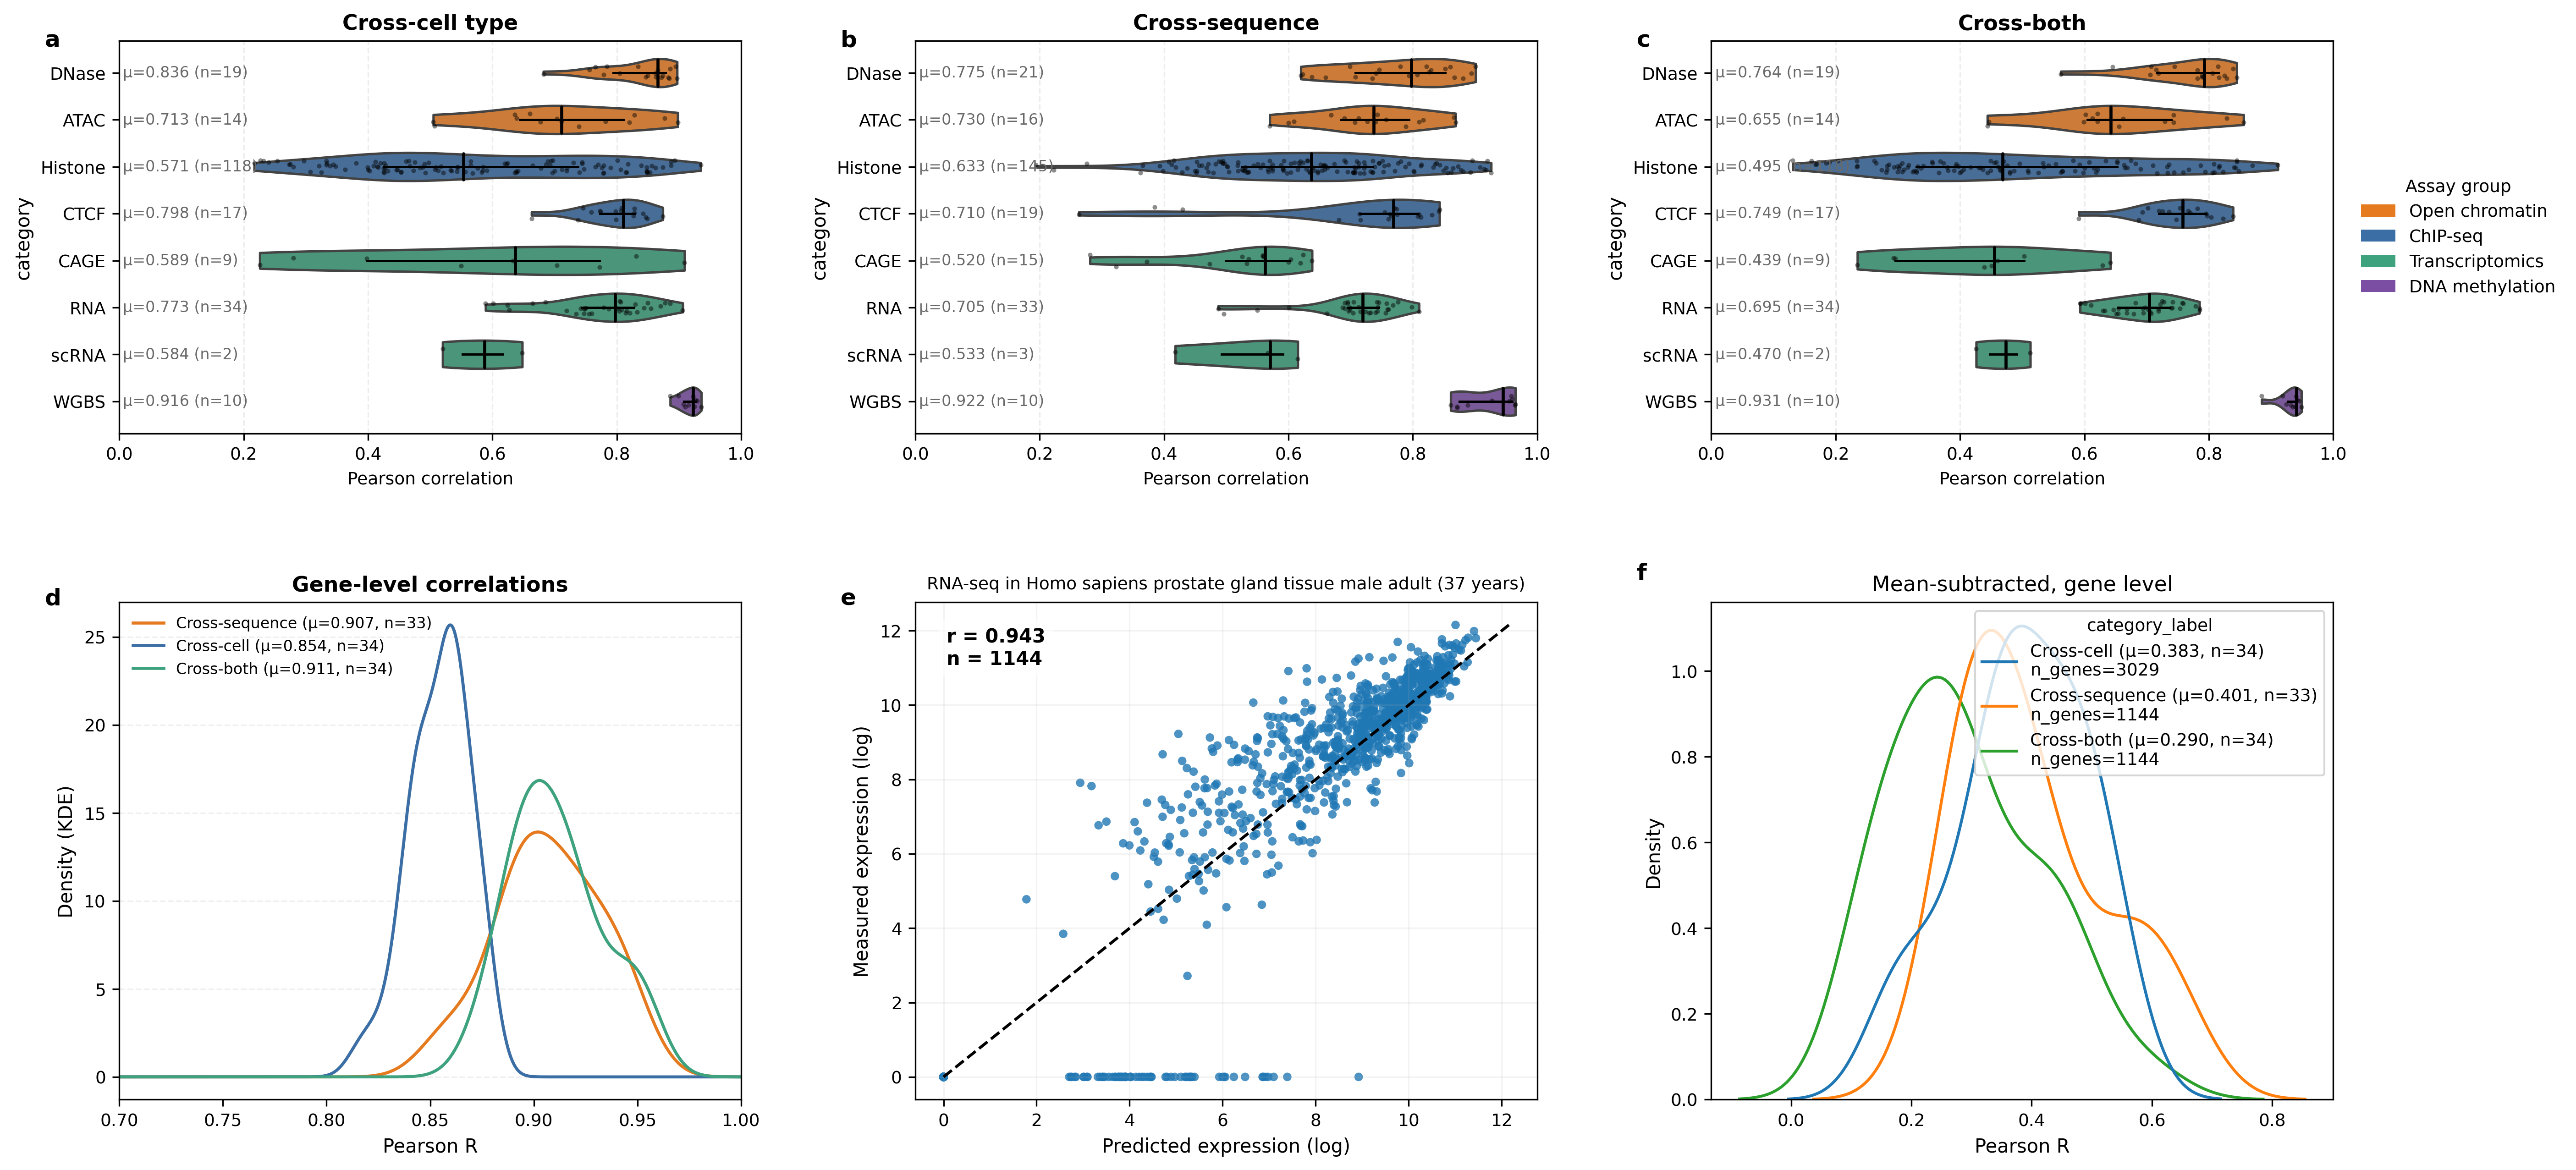

In [17]:
fig, axs = create_publication_figure(
     res_seq=res_cross_seq,
     res_cell=res_cross_cell,
     res_both=res_cross_both,
     gene_cross_seq=gene_cross_seq,
     gene_cross_cell=gene_cross_cell,
     gene_cross_both=gene_cross_both,
     encode_mat=encode_mat,
     grt_mat=grt_mat,
     genes_df=genes_df,
     cells_df=cells,
     igv_image_path=None,          
     sel_tissue='267_rna_total_encode',
     exclude_pairs=exclude,
     output_pdf='../figures_2/figure2.pdf',
     output_png=None
 )
plt.show()

## Sanity checks

In [87]:
genes_df = pd.read_csv('/project/deeprna/data/Homo_sapiens.gene_info.tsv', sep='\t')
coding_genes = genes_df.loc[genes_df.type_of_gene == 'protein-coding', 'Symbol'].values

genes_xboth = pd.read_csv('/project/deeprna_data/corgi-reproduction/processed_data_extended/figure2/gene_level_cross_both_genebody/all_expressions_grt.csv', index_col=0)
genes_xcell = pd.read_csv('/project/deeprna_data/corgi-reproduction/processed_data_extended/figure2/gene_level_cross_celltype_genebody/all_expressions_grt.csv', index_col=0)
genes_xregion = pd.read_csv('/project/deeprna_data/corgi-reproduction/processed_data_extended/figure2/gene_level_cross_region_genebody/all_expressions_grt.csv', index_col=0)

genes_xboth_encode = pd.read_csv('/project/deeprna_data/corgi-reproduction/processed_data_extended/figure2/gene_level_cross_both_genebody/all_expressions_encode.csv', index_col=0)
genes_xcell_encode = pd.read_csv('/project/deeprna_data/corgi-reproduction/processed_data_extended/figure2/gene_level_cross_celltype_genebody/all_expressions_encode.csv', index_col=0)
genes_xregion_encode = pd.read_csv('/project/deeprna_data/corgi-reproduction/processed_data_extended/figure2/gene_level_cross_region_genebody/all_expressions_encode.csv', index_col=0)


In [90]:
coding_genes_xboth = genes_xboth[genes_xboth.index.isin(coding_genes)]
coding_genes_xcell = genes_xcell[genes_xcell.index.isin(coding_genes)]
coding_genes_xregion = genes_xregion[genes_xregion.index.isin(coding_genes)]

coding_genes_xboth_encode = genes_xboth_encode[genes_xboth_encode.index.isin(coding_genes)]
coding_genes_xcell_encode = genes_xcell_encode[genes_xcell_encode.index.isin(coding_genes)]
coding_genes_xregion_encode = genes_xregion_encode[genes_xregion_encode.index.isin(coding_genes)]

In [91]:
cors = []
for i in range(genes_xregion.shape[1]):
    r, p = pearsonr(genes_xregion.iloc[:, i], genes_xregion_encode.iloc[:, i])
    cors.append(r)
print(f"Cross-region gene-level Pearson R: mean={np.mean(cors):.3f}, n={len(cors)}, n_genes={genes_xregion.shape[0]}")

cors = []
for i in range(coding_genes_xregion.shape[1]):
    r, p = pearsonr(coding_genes_xregion.iloc[:, i], coding_genes_xregion_encode.iloc[:, i])
    cors.append(r)
print(f"Cross-region coding gene-level Pearson R: mean={np.mean(cors):.3f}, n={len(cors)}, n_genes={coding_genes_xregion.shape[0]}")

Cross-region gene-level Pearson R: mean=0.939, n=33, n_genes=1076
Cross-region coding gene-level Pearson R: mean=0.939, n=33, n_genes=1072


In [92]:
cors = []
for i in range(genes_xcell.shape[1]):
    r, p = pearsonr(genes_xcell.iloc[:, i], genes_xcell_encode.iloc[:, i])
    cors.append(r)
print(f"Cross-cell gene-level Pearson R: mean={np.mean(cors):.3f}, n={len(cors)}, n_genes={genes_xcell.shape[0]}")

cors = []
for i in range(coding_genes_xcell.shape[1]):
    r, p = pearsonr(coding_genes_xcell.iloc[:, i], coding_genes_xcell_encode.iloc[:, i])
    cors.append(r)
print(f"Cross-cell coding gene-level Pearson R: mean={np.mean(cors):.3f}, n={len(cors)}, n_genes={coding_genes_xcell.shape[0]}")

Cross-cell gene-level Pearson R: mean=0.871, n=34, n_genes=2812
Cross-cell coding gene-level Pearson R: mean=0.871, n=34, n_genes=2795


In [93]:
cors = []
for i in range(genes_xboth.shape[1]):
    r, p = pearsonr(genes_xboth.iloc[:, i], genes_xboth_encode.iloc[:, i])
    cors.append(r)
print(f"Cross-both gene-level Pearson R: mean={np.mean(cors):.3f}, n={len(cors)}, n_genes={genes_xboth.shape[0]}")

cors = []
for i in range(coding_genes_xboth.shape[1]):
    r, p = pearsonr(coding_genes_xboth.iloc[:, i], coding_genes_xboth_encode.iloc[:, i])
    cors.append(r)
print(f"Cross-both coding gene-level Pearson R: mean={np.mean(cors):.3f}, n={len(cors)}, n_genes={coding_genes_xboth.shape[0]}")

Cross-both gene-level Pearson R: mean=0.937, n=34, n_genes=1076
Cross-both coding gene-level Pearson R: mean=0.937, n=34, n_genes=1072


In [94]:
# List of 0 expression genes in cross region and cross cell. Put only if it is exactly zero in all tissues, in both measured and predicted.
zero_genes = {'cross-region': set(), 'cross-cell': set(), 'cross-both': set()}
for gene in coding_genes_xregion_encode.index:
    if coding_genes_xregion_encode.loc[gene].max() < 0.1:
        if coding_genes_xregion.loc[gene].max() < 0.1:
            zero_genes['cross-region'].add(gene)
for gene in coding_genes_xcell_encode.index:
    if coding_genes_xcell_encode.loc[gene].max() < 0.1:
        if coding_genes_xcell.loc[gene].max() < 0.1:
            zero_genes['cross-cell'].add(gene)
for gene in coding_genes_xboth_encode.index:
    if coding_genes_xboth_encode.loc[gene].max() < 0.1:
        if coding_genes_xboth.loc[gene].max() < 0.1:
            zero_genes['cross-both'].add(gene)

In [95]:
for setting in zero_genes.keys():
    print(f"{setting}: number of genes with 0 measured expression in all tissues: {len(zero_genes[setting])}")

cross-region: number of genes with 0 measured expression in all tissues: 229
cross-cell: number of genes with 0 measured expression in all tissues: 99
cross-both: number of genes with 0 measured expression in all tissues: 229


In [99]:
# Avergae correlations, excluding genes with 0 expression in all tissues
coding_genes_xcell_nonzero = coding_genes_xcell[~coding_genes_xcell.index.isin(zero_genes['cross-cell'])]
coding_genes_xcell_encode_nonzero = coding_genes_xcell_encode[~coding_genes_xcell_encode.index.isin(zero_genes['cross-cell'])]

cors = []
for i in range(coding_genes_xcell_nonzero.shape[1]):
    r, p = pearsonr(coding_genes_xcell_nonzero.iloc[:, i], coding_genes_xcell_encode_nonzero.iloc[:, i])
    cors.append(r)
print(f"Cross-cell coding gene-level Pearson R (excluding 0 expression genes): mean={np.mean(cors):.4f}, n={len(cors)}, n_genes={coding_genes_xcell_nonzero.shape[0]}")

Cross-cell coding gene-level Pearson R (excluding 0 expression genes): mean=0.8498, n=34, n_genes=2696


In [103]:
coding_genes_xregion_nonzero = coding_genes_xregion[~coding_genes_xregion.index.isin(zero_genes['cross-region'])]
coding_genes_xregion_encode_nonzero = coding_genes_xregion_encode[~coding_genes_xregion_encode.index.isin(zero_genes['cross-region'])]
cors = []
for i in range(coding_genes_xregion_nonzero.shape[1]):
    r, p = pearsonr(coding_genes_xregion_nonzero.iloc[:, i], coding_genes_xregion_encode_nonzero.iloc[:, i])
    cors.append(r)
print(f"Cross-region coding gene-level Pearson R (excluding 0 expression genes): mean={np.mean(cors):.4f}, n={len(cors)}, n_genes={coding_genes_xregion_nonzero.shape[0]}")

Cross-region coding gene-level Pearson R (excluding 0 expression genes): mean=0.8681, n=33, n_genes=843


In [105]:
coding_genes_xboth_nonzero = coding_genes_xboth[~coding_genes_xboth.index.isin(zero_genes['cross-both'])]
coding_genes_xboth_encode_nonzero = coding_genes_xboth_encode[~coding_genes_xboth_encode.index.isin(zero_genes['cross-both'])]
cors = []
for i in range(coding_genes_xboth_nonzero.shape[1]):
    r, p = pearsonr(coding_genes_xboth_nonzero.iloc[:, i], coding_genes_xboth_encode_nonzero.iloc[:, i])
    cors.append(r)
print(f"Cross-both coding gene-level Pearson R (excluding 0 expression genes): mean={np.mean(cors):.4f}, n={len(cors)}, n_genes={coding_genes_xboth_nonzero.shape[0]}")

Cross-both coding gene-level Pearson R (excluding 0 expression genes): mean=0.8635, n=34, n_genes=843


In [ ]:
coding

In [121]:
coding_genes_xregion_nonzero_ms

,4_rna_polya_grt,23_rna_polya_grt,34_rna_polya_grt,43_rna_total_grt,57_rna_polya_grt,57_rna_total_grt,59_rna_polya_grt,59_rna_total_grt,69_rna_total_grt,78_rna_total_grt,...,262_rna_total_grt,274_rna_polya_grt,281_rna_polya_grt,294_rna_polya_grt,294_rna_total_grt,295_rna_polya_grt,352_rna_total_grt,356_rna_total_grt,372_rna_total_grt,390_rna_total_grt
name,,,,,,,,,,,,,,,,,,,,,
AAK1,-1.155493,-0.637493,0.291507,-0.415493,-0.547493,0.322507,-0.368493,0.231507,0.119507,0.590507,...,0.636507,0.010507,-2.596493,0.402507,0.765507,-1.037493,-0.229493,0.528507,0.870507,0.883507
ABCA1,-0.717478,-0.811478,-0.206478,-0.049478,0.261522,0.883522,-0.739478,-0.257478,0.106522,-0.398478,...,0.899522,-0.142478,-1.894478,0.370522,0.699522,-1.123478,0.010522,0.528522,-0.439478,-0.465478
ABCC4,-1.090478,-0.688478,0.423522,-0.556478,-0.936478,0.134522,-0.435478,0.346522,0.106522,0.077522,...,0.838522,0.026522,-2.149478,0.372522,0.744522,-1.009478,-0.128478,0.711522,0.754522,0.768522
ABHD11,-0.366090,0.138910,0.039910,0.173910,0.473910,0.227910,0.532910,0.472910,0.516910,0.134910,...,0.129910,0.260910,-0.619090,-0.173090,-0.435090,0.517910,-0.729090,-0.004090,-0.217090,-0.271090
ABITRAM,-0.002448,-0.137448,-0.227448,0.130552,0.034552,0.202552,0.278552,0.332552,0.256552,0.404552,...,0.144552,0.209552,-1.363448,0.037552,0.262552,-0.225448,-0.439448,0.057552,0.130552,0.173552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZDHHC14,-1.376030,-1.314030,-1.063030,-0.759030,-0.912030,0.171970,-0.418030,0.254970,0.223970,0.395970,...,0.914970,0.690970,-2.180030,0.918970,1.206970,-1.408030,-0.350030,0.805970,1.355970,1.340970
ZER1,-0.636418,-0.210418,-0.006418,-0.375418,0.138582,0.053582,0.269582,0.433582,0.396582,0.401582,...,0.358582,0.357582,-1.415418,0.266582,0.207582,-0.035418,-0.835418,0.195582,0.587582,0.594582
ZNF395,-0.442134,-0.137134,0.156866,-0.190134,-0.123134,0.140866,-0.127134,0.176866,0.477866,0.083866,...,0.543866,0.107866,-1.479134,-0.054134,0.050866,-0.596134,-0.549134,0.258866,0.190866,0.166866


In [124]:
coding_genes_xboth_encode_nonzero_ms

,46_rna_total_encode,47_rna_polya_encode,47_rna_total_encode,49_rna_total_encode,50_rna_total_encode,54_rna_polya_encode,105_rna_total_encode,159_rna_polya_encode,159_rna_total_encode,160_rna_polya_encode,...,276_rna_total_encode,277_rna_total_encode,278_rna_total_encode,288_rna_total_encode,318_rna_total_encode,319_rna_total_encode,320_rna_total_encode,321_rna_total_encode,323_rna_total_encode,324_rna_total_encode
name,,,,,,,,,,,,,,,,,,,,,
AAK1,0.188478,-0.521522,0.063478,-0.525522,-0.080522,-0.629522,0.446478,-1.276522,-0.065522,-1.022522,...,-0.125522,0.234478,-0.096522,0.404478,-0.206522,0.105478,-0.147522,0.015478,0.469478,0.455478
ABCA1,-0.668537,-0.949537,-0.374537,-1.032537,0.153463,-1.015537,0.374463,-1.677537,0.261463,-1.646537,...,1.367463,1.258463,0.926463,1.108463,0.525463,1.139463,0.486463,0.784463,1.026463,0.705463
ABCC4,0.590806,-0.296194,0.284806,-0.858194,0.050806,-1.007194,-0.542194,-1.412194,0.330806,-2.118194,...,-0.978194,0.044806,-0.571194,0.367806,-0.156194,1.000806,0.561806,0.039806,1.077806,0.934806
ABHD11,0.046388,0.429388,0.197388,0.309388,0.495388,0.139388,0.347388,0.799388,0.312388,-0.019612,...,-0.203612,-0.346612,-0.453612,-0.615612,0.168388,-0.136612,-0.028612,0.147388,0.052388,0.008388
ABITRAM,-0.329881,-0.166881,-0.036881,-0.297881,0.117119,-0.011881,0.354119,0.314119,0.379119,-0.014881,...,-0.503881,-0.326881,-0.277881,0.208119,-0.170881,-0.018881,-0.196881,-0.276881,0.328119,0.289119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZDHHC14,0.364821,-0.579179,-0.104179,-1.102179,-0.651179,-0.868179,-0.146179,-2.040179,-0.109179,-2.475179,...,1.010821,0.825821,0.469821,0.930821,-0.109179,-0.043179,-0.154179,0.327821,1.590821,1.592821
ZER1,-0.242448,-0.024448,0.193552,-0.303448,0.301552,-0.191448,0.410552,-0.385448,-0.256448,-0.192448,...,0.236552,-0.200448,0.128552,-0.260448,-0.039448,0.348552,0.078552,0.140552,0.405552,0.419552
ZNF395,-0.341403,-0.520403,-0.240403,-0.320403,-0.164403,-0.777403,0.200597,-0.604403,0.102597,-0.215403,...,0.371597,0.163597,0.269597,0.294597,0.486597,0.678597,0.584597,0.560597,0.536597,0.436597


In [125]:
# Mean-subtracted gene level correlations

n_tissue_xregion = coding_genes_xregion_nonzero.shape[1]
coding_genes_xregion_xboth_nonzero = pd.concat([coding_genes_xregion_nonzero, coding_genes_xboth_nonzero], axis=1)
coding_genes_xregion_xboth_nonzero_ms = coding_genes_xregion_xboth_nonzero.sub(coding_genes_xregion_xboth_nonzero.mean(axis=1), axis=0)
coding_genes_xregion_nonzero_ms = coding_genes_xregion_xboth_nonzero_ms.iloc[:, :n_tissue_xregion]
coding_genes_xboth_nonzero_ms = coding_genes_xregion_xboth_nonzero_ms.iloc[:, n_tissue_xregion:]

coding_genes_xboth_nonzero_encode = pd.concat([coding_genes_xregion_encode_nonzero, coding_genes_xboth_encode_nonzero], axis=1)
coding_genes_xboth_nonzero_encode_ms = coding_genes_xboth_nonzero_encode.sub(coding_genes_xboth_nonzero_encode.mean(axis=1), axis=0)
coding_genes_xregion_encode_nonzero_ms = coding_genes_xboth_nonzero_encode_ms.iloc[:, :n_tissue_xregion]
coding_genes_xboth_encode_nonzero_ms = coding_genes_xboth_nonzero_encode_ms.iloc[:, n_tissue_xregion:]

cors = []
for i in range(coding_genes_xregion_nonzero_ms.shape[1]):
    r, p = pearsonr(coding_genes_xregion_nonzero_ms.iloc[:, i], coding_genes_xregion_encode_nonzero_ms.iloc[:, i])
    cors.append(r)
print(f"Cross-region coding gene-level mean-subtracted Pearson R: mean={np.mean(cors):.4f}, n={len(cors)}, n_genes={coding_genes_xregion_nonzero_ms.shape[0]}")

cors = []
for i in range(coding_genes_xboth_nonzero_ms.shape[1]):
    r, p = pearsonr(coding_genes_xboth_nonzero_ms.iloc[:, i], coding_genes_xboth_encode_nonzero_ms.iloc[:, i])
    cors.append(r)
print(f"Cross-both coding gene-level mean-subtracted Pearson R: mean={np.mean(cors):.4f}, n={len(cors)}, n_genes={coding_genes_xboth_nonzero_ms.shape[0]}")

Cross-region coding gene-level mean-subtracted Pearson R: mean=0.4199, n=33, n_genes=843
Cross-both coding gene-level mean-subtracted Pearson R: mean=0.3175, n=34, n_genes=843


In [126]:
coding_genes_xcell_nonzero_ms = coding_genes_xcell_nonzero.sub(coding_genes_xcell_nonzero.mean(axis=1), axis=0)
coding_genes_xcell_encode_nonzero_ms = coding_genes_xcell_encode_nonzero.sub(coding_genes_xcell_encode_nonzero.mean(axis=1), axis=0)
cors = []
for i in range(coding_genes_xcell_nonzero_ms.shape[1]):
    r, p = pearsonr(coding_genes_xcell_nonzero_ms.iloc[:, i], coding_genes_xcell_encode_nonzero_ms.iloc[:, i])
    cors.append(r)
print(f"Cross-cell coding gene-level mean-subtracted Pearson R: mean={np.mean(cors):.4f}, n={len(cors)}, n_genes={coding_genes_xcell_nonzero_ms.shape[0]}")

Cross-cell coding gene-level mean-subtracted Pearson R: mean=0.4014, n=34, n_genes=2696


In [127]:
coding_genes_xregion_nonzero_ms = coding_genes_xregion_nonzero.sub(coding_genes_xregion_nonzero.mean(axis=1), axis=0)
coding_genes_xregion_encode_nonzero_ms = coding_genes_xregion_encode_nonzero.sub(coding_genes_xregion_encode_nonzero.mean(axis=1), axis=0)
cors = []
for i in range(coding_genes_xregion_nonzero_ms.shape[1]):
    r, p = pearsonr(coding_genes_xregion_nonzero_ms.iloc[:, i], coding_genes_xregion_encode_nonzero_ms.iloc[:, i])
    cors.append(r)
print(f"Cross-region coding gene-level mean-subtracted Pearson R: mean={np.mean(cors):.4f}, n={len(cors)}, n_genes={coding_genes_xregion_nonzero_ms.shape[0]}")

Cross-region coding gene-level mean-subtracted Pearson R: mean=0.4228, n=33, n_genes=843


In [128]:
coding_genes_xboth_nonzero_ms = coding_genes_xboth_nonzero.sub(coding_genes_xboth_nonzero.mean(axis=1), axis=0)
coding_genes_xboth_encode_nonzero_ms = coding_genes_xboth_encode_nonzero.sub(coding_genes_xboth_encode_nonzero.mean(axis=1), axis=0)
cors = []
for i in range(coding_genes_xboth_nonzero_ms.shape[1]):
    r, p = pearsonr(coding_genes_xboth_nonzero_ms.iloc[:, i], coding_genes_xboth_encode_nonzero_ms.iloc[:, i])
    cors.append(r)
print(f"Cross-both coding gene-level mean-subtracted Pearson R: mean={np.mean(cors):.4f}, n={len(cors)}, n_genes={coding_genes_xboth_nonzero_ms.shape[0]}")

Cross-both coding gene-level mean-subtracted Pearson R: mean=0.3191, n=34, n_genes=843


In [111]:
pd.concat([coding_genes_xregion_nonzero, coding_genes_xboth_nonzero], axis=1)

,4_rna_polya_grt,23_rna_polya_grt,34_rna_polya_grt,43_rna_total_grt,57_rna_polya_grt,57_rna_total_grt,59_rna_polya_grt,59_rna_total_grt,69_rna_total_grt,78_rna_total_grt,...,276_rna_total_grt,277_rna_total_grt,278_rna_total_grt,288_rna_total_grt,318_rna_total_grt,319_rna_total_grt,320_rna_total_grt,321_rna_total_grt,323_rna_total_grt,324_rna_total_grt
name,,,,,,,,,,,,,,,,,,,,,
AAK1,10.386,10.904,11.833,11.126,10.994,11.864,11.173,11.773,11.661,12.132,...,11.693,11.541,11.482,12.202,11.742,12.040,11.804,11.976,11.666,11.638
ABCA1,11.003,10.909,11.514,11.671,11.982,12.604,10.981,11.463,11.827,11.322,...,12.046,11.913,11.852,12.595,12.051,12.268,12.034,12.220,11.882,11.856
ABCC4,10.882,11.284,12.396,11.416,11.036,12.107,11.537,12.319,12.079,12.050,...,12.528,12.298,12.296,12.827,12.213,12.707,12.228,12.573,12.002,11.917
ABHD11,9.066,9.571,9.472,9.606,9.906,9.660,9.965,9.905,9.949,9.567,...,9.490,9.408,9.593,9.066,9.512,9.322,9.501,9.437,9.297,9.238
ABITRAM,10.486,10.351,10.261,10.619,10.523,10.691,10.767,10.821,10.745,10.893,...,10.392,10.256,10.349,10.560,10.432,10.510,10.525,10.511,10.430,10.413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZDHHC14,9.861,9.923,10.174,10.478,10.325,11.409,10.819,11.492,11.461,11.633,...,11.338,11.265,11.004,12.056,11.410,11.889,11.524,11.792,11.239,11.224
ZER1,10.115,10.541,10.745,10.376,10.890,10.805,11.021,11.185,11.148,11.153,...,10.825,10.509,10.802,10.789,10.596,10.751,10.711,10.775,10.729,10.719
ZNF395,10.813,11.118,11.412,11.065,11.132,11.396,11.128,11.432,11.733,11.339,...,11.420,11.181,11.378,11.448,11.375,11.442,11.460,11.483,11.202,11.149


In [109]:
coding_genes_xboth_nonzero

,46_rna_total_grt,47_rna_polya_grt,47_rna_total_grt,49_rna_total_grt,50_rna_total_grt,54_rna_polya_grt,105_rna_total_grt,159_rna_polya_grt,159_rna_total_grt,160_rna_polya_grt,...,276_rna_total_grt,277_rna_total_grt,278_rna_total_grt,288_rna_total_grt,318_rna_total_grt,319_rna_total_grt,320_rna_total_grt,321_rna_total_grt,323_rna_total_grt,324_rna_total_grt
name,,,,,,,,,,,,,,,,,,,,,
AAK1,11.868,10.967,11.813,11.529,11.758,11.226,11.669,10.613,11.194,10.737,...,11.693,11.541,11.482,12.202,11.742,12.040,11.804,11.976,11.666,11.638
ABCA1,11.743,11.124,11.710,11.511,11.678,11.652,11.821,11.272,11.640,11.241,...,12.046,11.913,11.852,12.595,12.051,12.268,12.034,12.220,11.882,11.856
ABCC4,12.210,11.285,12.148,11.815,12.147,11.307,11.899,10.886,11.505,10.947,...,12.528,12.298,12.296,12.827,12.213,12.707,12.228,12.573,12.002,11.917
ABHD11,9.319,9.494,9.477,9.525,9.512,9.675,9.459,9.675,9.621,9.552,...,9.490,9.408,9.593,9.066,9.512,9.322,9.501,9.437,9.297,9.238
ABITRAM,10.481,10.378,10.512,10.503,10.510,10.544,10.415,10.509,10.562,10.347,...,10.392,10.256,10.349,10.560,10.432,10.510,10.525,10.511,10.430,10.413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZDHHC14,11.538,10.501,11.552,11.073,11.463,10.679,11.379,10.150,10.877,10.265,...,11.338,11.265,11.004,12.056,11.410,11.889,11.524,11.792,11.239,11.224
ZER1,10.816,10.649,10.974,10.775,10.934,10.803,10.786,10.517,10.652,10.486,...,10.825,10.509,10.802,10.789,10.596,10.751,10.711,10.775,10.729,10.719
ZNF395,11.270,10.980,11.438,11.257,11.425,11.208,11.187,11.035,11.326,10.978,...,11.420,11.181,11.378,11.448,11.375,11.442,11.460,11.483,11.202,11.149


In [47]:
# Bed files of 0 expression gene body coordinates
exons_xregion = pd.read_csv('/project/deeprna_data/corgi-reproduction/data/exons_coding_fold3.bed', sep='\t', header=None, names=['chr', 'start', 'end', 'gene'])
exons_xcell = pd.read_csv('/project/deeprna_data/corgi-reproduction/data/exons_trainingfolds_subset.bed', sep='\t', header=None, names=['chr', 'start', 'end', 'gene'])

In [54]:
exons_xregion_zero = exons_xregion[exons_xregion['gene'].isin(zero_genes['cross-region'])]
exons_xregion_zero.to_csv('/project/deeprna/data/revision/cross_region_zero_genes.bed', sep='\t', header=False, index=False)

exons_xcell_zero = exons_xcell[exons_xcell['gene'].isin(zero_genes['cross-cell'])]
exons_xcell_zero.to_csv('/project/deeprna/data/revision/cross_cell_zero_genes.bed', sep='\t', header=False, index=False)

exons_xboth_zero = exons_xregion[exons_xregion['gene'].isin(zero_genes['cross-both'])]
exons_xboth_zero.to_csv('/project/deeprna/data/revision/cross_both_zero_genes.bed', sep='\t', header=False, index=False)

In [ ]:
# Filter out genes 